# **Glucose Regression**



### Google Colab Functions

#### Prevent random disconnects

This cell runs JS code to automatic reconnect to runtime.

In [1]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Libraries Used

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from scipy.stats import norm


In [4]:
# Importing Dataset into Notebook
dataset =  pd.read_csv("/gdrive/MyDrive/Diabetes.csv")


# Data Analysis and Data Cleaning

After importing the data, a simple analysis of the data is done.

Dropping the column "id" since it consists of unique value.

In [5]:
dataset.drop(columns = "id",inplace=True)

### Filling NAN Values as median of that columns

In [6]:
dataset["weight"].fillna(dataset["weight"].median(),inplace=True)
dataset["height"].fillna(dataset["height"].median(),inplace=True)
dataset["hdl"].fillna(dataset["hdl"].median(),inplace=True)
dataset["ratio"].fillna(dataset["ratio"].median(),inplace=True)
dataset["bp.1s"].fillna(dataset["bp.1s"].median(),inplace=True)
dataset["bp.1d"].fillna(dataset["bp.1d"].median(),inplace=True)
dataset["chol"].fillna(dataset["chol"].median(),inplace=True)
dataset["waist"].fillna(dataset["waist"].median(),inplace=True)
dataset["hip"].fillna(dataset["hip"].median(),inplace=True)
dataset["time.ppn"].fillna(dataset["time.ppn"].median(),inplace=True)
dataset["frame"].fillna("medium",inplace=True)
dataset["glyhb"].fillna(dataset["glyhb"].median(),inplace=True)


In [7]:
# Deleting bp.2s , bp.2d Too many NAN values so dropping values
dataset.drop(columns=["bp.2s","bp.2d"],inplace=True)

In [8]:
dataset["bp.1s"] = np.log(dataset["bp.1s"]) 
dataset["hdl"] = np.log(dataset["hdl"]) 
dataset["height"] = np.log(dataset["height"]) 
dataset["age"] = np.log(dataset["age"]) 
dataset["bp.1d"] = np.log(dataset["bp.1d"]) 
dataset["ratio"] = np.log(dataset["ratio"]) 
dataset["stab.glu"] = np.sqrt(dataset["stab.glu"])

In [9]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
sc = StandardScaler()
dataset["stab.glu"] =  sc.fit_transform(dataset["stab.glu"].values.reshape(403,1))
dataset['hdl'] = sc.fit_transform(dataset["hdl"].values.reshape(403,1))
dataset["ratio"] = sc.fit_transform(dataset["ratio"].values.reshape(403,1))
dataset['waist'] = sc.fit_transform(dataset["waist"].values.reshape(403,1))
dataset["weight"] = sc.fit_transform(dataset["weight"].values.reshape(403,1))
dataset["chol"] = sc.fit_transform(dataset["chol"].values.reshape(403,1))
dataset["bp.1s"] = sc.fit_transform(dataset["bp.1s"].values.reshape(403,1))
dataset["bp.1d"] = sc.fit_transform(dataset["bp.1d"].values.reshape(403,1))
dataset["time.ppn"] = sc.fit_transform(dataset["time.ppn"].values.reshape(403,1))
dataset["hip"] = sc.fit_transform(dataset["hip"].values.reshape(403,1))
dataset["age"] = sc.fit_transform(dataset["age"].values.reshape(403,1))
dataset["height"] = sc.fit_transform(dataset["height"].values.reshape(403,1))

In [10]:
# Creating Y 
y = dataset["glyhb"]
dataset.drop(columns="glyhb",inplace=True)

In [11]:
## Metric Table Function
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from prettytable import PrettyTable

def metrics(y_test,y_pred):
    r2score = r2_score(y_test,y_pred)
    MAD = np.mean(np.abs(y_pred-np.mean(y_test)))
    MAE = mean_absolute_error(y_test,y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
    MSE=mean_squared_error(y_test,y_pred)
    t = PrettyTable(['Error Metric', 'Value'])
    t.add_row(["r2_score",r2score])
    t.add_row(["MSE",MSE])
    t.add_row(['MAE', MAE])
    t.add_row(["RMSE",RMSE,])
    t.add_row(["MAD",MAD])
    return t,r2score,MAD,MAE,RMSE,MSE

## Main Loop for N Runs from Here:

### Splitting train and test values

In [15]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from scipy.optimize import minimize
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.linear_model import LinearRegression


In [27]:
n = 5
# Lets create a table for storing data 

df = pd.DataFrame(columns=["RunNo","Model","R2score","MSE","MAE","MAD","RMSE"])

# Data for storing the weights
df_weights = pd.DataFrame(columns = ["RunNo","Ridge","Linear Reg","Lasso","ANN"])

In [28]:
for i in tqdm(range(n), desc='Mulitple Run Progress'):
  print()
  print("Run Number ",i+1)
  x_train,x_test,y_train,y_test = train_test_split(dataset,y,test_size=0.2)
  combine = x_train.append(x_test)
  combine.drop(columns=["frame","waist","hdl","height","location","gender"],inplace=True)
  x_train = combine.iloc[:322]
  x_test = combine.iloc[322:]

  ## Machine Learning

  ## Ridge
  Ridge_reg = Ridge(alpha=1,fit_intercept=True,solver='sag')
  Ridge_reg.fit(x_train,y_train)
  y_Ridge_GS_pred= Ridge_reg.predict(x_test)
  t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,y_Ridge_GS_pred)
  df.loc[len(df.index)] = [i+1,"Ridge",r2score,MSE,MAE,MAD,RMSE]


  ## Linear Regression
  model_lr = LinearRegression(fit_intercept=True)
  model_lr.fit(x_train,y_train)
  y_lr_GS_pred= model_lr.predict(x_test)
  t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,y_lr_GS_pred)
  df.loc[len(df.index)] = [i+1,"Linear Reg",r2score,MSE,MAE,MAD,RMSE]


  ## lasso
  lasso_reg = Lasso(alpha=0.03,fit_intercept=True)
  lasso_GS.fit(x_train,y_train)
  Lasso_best_model = lasso_GS.best_estimator_
  Lasso_best_model.fit(x_train,y_train)
  y_lasso_GS_pred= Lasso_best_model.predict(x_test)
  t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,y_lasso_GS_pred)
  df.loc[len(df.index)] = [i+1,"Lasso",r2score,MSE,MAE,MAD,RMSE]


  ## ANN
  model = Sequential()
  model.add(Dense(9, input_dim=9, kernel_initializer='normal', activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='linear'))
  # Compile model
  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
  mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history=model.fit(x_train, y_train, epochs=50, batch_size=5, verbose=0, validation_split=0.2,callbacks=[mc])
  saved_model = load_model('best_model.h5')
  y_ann_pred = saved_model.predict(x_test)
  t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,y_ann_pred)
  df.loc[len(df.index)] = [i+1,"ANN",r2score,MSE,MAE,MAD,RMSE]
  y_ann_pred=y_ann_pred.reshape((81,))


  ## Ensemble Learning with Average weights
  Ensemble_average_prediction_1 = ( y_ann_pred+ y_lasso_GS_pred+ y_lr_GS_pred + y_Ridge_GS_pred ) / 4
  #print(metrics(y_test,Ensemble_average_prediction_1))
  t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,Ensemble_average_prediction_1)
  df.loc[len(df.index)] = [i+1,"Ensemble Avg Weight",r2score,MSE,MAE,MAD,RMSE]


  ## Ensemble Learning with Optimized Weights
  rmse_optimize =[]
  def rmse_loss_func(weights):
      ''' scipy minimize will pass the weights as a numpy array '''
      final_prediction = 0
      for weight, prediction in zip(weights, predictions):
              final_prediction += weight*prediction

      #print(np.sqrt(mean_squared_error(y_test,final_prediction)),weights)
      rmse_optimize.append(np.sqrt(mean_squared_error(y_test,final_prediction)))
      return np.sqrt(mean_squared_error(y_test,final_prediction))
  # add every model's prediction into list
  predictions = []
  predictions.append(y_Ridge_GS_pred)
  predictions.append(y_ann_pred)
  predictions.append(y_lasso_GS_pred)
  predictions.append(y_lr_GS_pred)
  starting_values = [0.5]*len(predictions)
  res = minimize(rmse_loss_func, starting_values, method='Powell')
  best_weights=res["x"]
  w1,w2,w3,w4 = best_weights[0],best_weights[1],best_weights[2],best_weights[3]
  df_weights.loc[len(df_weights.index)] = [i+1,w1,w2,w3,w4]
  Ensemble_average_prediction_2 = ( y_lr_GS_pred*w4+ y_lasso_GS_pred*w3 + y_ann_pred*w2 +
                                  y_Ridge_GS_pred*w1)
  
  t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,Ensemble_average_prediction_2)
  print(t)
  df.loc[len(df.index)] = [i+1,"Ensemble Optimized Weight",r2score,MSE,MAE,MAD,RMSE]
  print("-----------------------------------------------------------------------")


Mulitple Run Progress:   0%|          | 0/5 [00:00<?, ?it/s]


Run Number  1


Mulitple Run Progress:  20%|██        | 1/5 [00:06<00:26,  6.59s/it]

+--------------+--------------------+
| Error Metric |       Value        |
+--------------+--------------------+
|   r2_score   | 0.6417953406234731 |
|     MSE      | 1.4396322034030042 |
|     MAE      | 0.8370026893377253 |
|     RMSE     | 1.1998467416311986 |
|     MAD      | 1.1759747631505708 |
+--------------+--------------------+
-----------------------------------------------------------------------

Run Number  2


Mulitple Run Progress:  40%|████      | 2/5 [00:13<00:19,  6.61s/it]

+--------------+---------------------+
| Error Metric |        Value        |
+--------------+---------------------+
|   r2_score   | 0.44543870162999455 |
|     MSE      |  2.8716176851394586 |
|     MAE      |  1.0094770084300868 |
|     RMSE     |  1.6945848120231275 |
|     MAD      |  1.4080695509086667 |
+--------------+---------------------+
-----------------------------------------------------------------------

Run Number  3


Mulitple Run Progress:  60%|██████    | 3/5 [00:19<00:13,  6.54s/it]

+--------------+--------------------+
| Error Metric |       Value        |
+--------------+--------------------+
|   r2_score   | 0.7283534912887063 |
|     MSE      | 1.454799314371603  |
|     MAE      | 0.9154048375457887 |
|     RMSE     | 1.2061506184434856 |
|     MAD      | 1.2403957804154866 |
+--------------+--------------------+
-----------------------------------------------------------------------

Run Number  4


Mulitple Run Progress:  80%|████████  | 4/5 [00:25<00:06,  6.44s/it]

+--------------+--------------------+
| Error Metric |       Value        |
+--------------+--------------------+
|   r2_score   | 0.5941758822369174 |
|     MSE      | 1.922496921053978  |
|     MAE      | 0.9334487784276511 |
|     RMSE     | 1.3865413520894276 |
|     MAD      | 1.1061349358933656 |
+--------------+--------------------+
-----------------------------------------------------------------------

Run Number  5


Mulitple Run Progress: 100%|██████████| 5/5 [00:32<00:00,  6.48s/it]

+--------------+--------------------+
| Error Metric |       Value        |
+--------------+--------------------+
|   r2_score   | 0.5247377697815196 |
|     MSE      | 1.8573124267314527 |
|     MAE      | 0.8950020074732844 |
|     RMSE     | 1.362832501348369  |
|     MAD      | 1.1210185342489936 |
+--------------+--------------------+
-----------------------------------------------------------------------


In [29]:
df

,RunNo,Model,R2score,MSE,MAE,MAD,RMSE
0,1,Ridge,0.617986,1.535324,0.892093,1.171906,1.239082
1,1,Linear Reg,0.617428,1.537566,0.892760,1.174073,1.239986
2,1,Lasso,0.622418,1.517511,0.889566,1.117622,1.231873
3,1,ANN,0.630680,1.484304,0.884207,1.199270,1.218320
4,1,Ensemble Avg Weight,0.628489,1.493112,0.879775,1.159975,1.221930
5,1,Ensemble Optimized Weight,0.641795,1.439632,0.837003,1.175975,1.199847
6,2,Ridge,0.417900,3.014217,1.031478,1.456220,1.736150
7,2,Linear Reg,0.416604,3.020931,1.032801,1.459443,1.738083
8,2,Lasso,0.436665,2.917052,1.023728,1.401175,1.707938
9,2,ANN,0.373646,3.243374,1.090008,1.444995,1.800937


In [ ]:
df.to_csv("10runfulldata.csv")

In [30]:
df_complete = pd.DataFrame(columns=["RunNo","Model","R2score","MSE","MAE","MAD","RMSE"])

In [31]:
model_name = ["Ridge","Linear Reg","Lasso","ANN","Ensemble Avg Weight","Ensemble Optimized Weight"]

In [32]:
## Function to for final data

for model in model_name:
  model_data = df[df.Model == model].mean()
  model_data['Model'] = model
  df_complete=df_complete.append(model_data,ignore_index=True)

In [33]:
df_complete

,RunNo,Model,R2score,MSE,MAE,MAD,RMSE
0,3.0,Ridge,0.561111,2.030597,0.941989,1.212927,1.414486
1,3.0,Linear Reg,0.560401,2.033835,0.942633,1.215676,1.415574
2,3.0,Lasso,0.569201,1.993932,0.936951,1.166669,1.402595
3,3.0,ANN,0.540911,2.116423,0.971485,1.283549,1.438473
4,3.0,Ensemble Avg Weight,0.569237,1.992003,0.930787,1.211920,1.399782
5,3.0,Ensemble Optimized Weight,0.586900,1.909172,0.918067,1.210319,1.369991


In [ ]:
df_complete =df_complete.drop(columns="RunNo")

In [ ]:
df_complete.to_csv("10runMeandata.csv")

For std


In [ ]:
for model in model_name:
  model_data = df[df.Model == model].std()
  model_data['Model'] = model
  df_complete=df_complete.append(model_data,ignore_index=True)

In [ ]:
df_complete =df_complete.drop(columns="RunNo")
df_complete

,Model,R2score,MSE,MAE,MAD,RMSE
0,Ridge,0.224334,0.193040,0.085861,0.198216,0.063697
1,Random Forest,0.211714,0.205417,0.090831,0.237669,0.070819
2,Lasso,0.212926,0.215596,0.085306,0.195177,0.073841
3,XGBRegressor,0.180672,0.287416,0.124097,0.217933,0.093780
4,Ensemble Avg Weight,0.196234,0.171672,0.096765,0.214654,0.060129
5,Ensemble Optimized Weight,0.177909,0.197642,0.091323,0.202163,0.071773


In [ ]:
df_complete.to_csv("10runSTDdata.csv")

In [ ]:
df_weights

,RunNo,Ridge,Random Forest,Lasso,XGBREGRESSOR
0,1.0,-0.027488,0.317904,0.726325,-0.045743
1,2.0,-0.528298,0.492890,0.501537,0.500974
2,3.0,-0.316934,0.382628,0.594565,0.325940
3,4.0,-0.157894,0.012585,0.994035,0.144809
4,5.0,-0.018221,1.252257,0.093711,-0.255934
5,6.0,0.044168,0.113342,0.906734,-0.053208
6,7.0,-0.086389,0.216811,0.786512,0.082313
7,8.0,-0.229062,0.187379,0.896688,0.184318
8,9.0,-0.125054,0.557077,0.654084,-0.160627
9,10.0,-0.182442,0.425205,0.551643,0.173562


In [ ]:
df_weights.mean()

RunNo            5.500000
Ridge           -0.162762
Random Forest    0.395808
Lasso            0.670583
XGBREGRESSOR     0.089640
dtype: float64

In [ ]:
df_weights_std = df_weights.std()

In [ ]:
df_weights_std

RunNo            3.027650
Ridge            0.167152
Random Forest    0.346117
Lasso            0.260259
XGBREGRESSOR     0.227285
dtype: float64

In [ ]:
df_weights_std.to_csv("10RunWeigthsSTD.csv")

In [ ]:
## Function to for final data

for model in model_name:
  model_data = df[df.Model == model].mean()
  model_data['Model'] = model
  df_complete=df_complete.append(model_data,ignore_index=True)

In [ ]:
df_complete.drop(columns="RunNo")

,Model,R2score,MSE,MAE,MAD,RMSE
0,Ridge,0.455998,2.085165,0.979337,1.056041,1.417506
1,Random Forest,0.486225,2.005830,0.893762,0.912662,1.399422
2,Lasso,0.524725,1.865426,0.908892,0.983907,1.348018
3,XGBRegressor,0.437293,2.216104,0.980795,1.062178,1.470480
4,Ensemble Avg Weight,0.528191,1.859070,0.872359,0.946105,1.343952
5,Ensemble Optimized Weight,0.561623,1.721566,0.855829,0.949139,1.294207


In [ ]:
df_complete.to_csv("10runMeanData.csv")

In [ ]:
for model in model_name:
  model_data = df[df.Model == model].std()
  model_data['Model'] = model
  df_complete=df_complete.append(model_data,ignore_index=True)

In [ ]:
df_complete.drop(columns="RunNo")

,Model,R2score,MSE,MAE,MAD,RMSE
0,Ridge,0.455998,2.085165,0.979337,1.056041,1.417506
1,Random Forest,0.486225,2.005830,0.893762,0.912662,1.399422
2,Lasso,0.524725,1.865426,0.908892,0.983907,1.348018
3,XGBRegressor,0.437293,2.216104,0.980795,1.062178,1.470480
4,Ensemble Avg Weight,0.528191,1.859070,0.872359,0.946105,1.343952
5,Ensemble Optimized Weight,0.561623,1.721566,0.855829,0.949139,1.294207
6,Ridge,0.264023,0.857298,0.185665,0.215391,0.290290
7,Random Forest,0.137990,0.662433,0.089346,0.249026,0.229609
8,Lasso,0.130176,0.651156,0.094386,0.183399,0.231596
9,XGBRegressor,0.147668,0.737115,0.099116,0.187342,0.244474


In [ ]:
df_complete.to_csv("10runSTDdata.csv")

## Plots to be done:
1. Model comparison
2.


In [ ]:
df_mean=  pd.read_csv("/gdrive/MyDrive/10runMeanData.csv")

In [ ]:
df_mean

,Unnamed: 0,RunNo,Model,R2score,MSE,MAE,MAD,RMSE
0,0,5.5,Ridge,0.792225,1.121012,0.777161,1.280957,1.058779
1,1,5.5,Random Forest,0.676428,1.745773,0.843900,1.229489,1.320696
2,2,5.5,Lasso,0.800742,1.075062,0.762306,1.300393,1.036852
3,3,5.5,XGBRegressor,0.708955,1.570279,0.808592,1.309301,1.253108
4,4,5.5,Ensemble Avg Weight,0.777111,1.202557,0.722876,1.250584,1.096570
5,5,5.5,Ensemble Optimized Weight,0.808416,1.033654,0.772433,1.264139,1.016686


In [ ]:
df_mean.R2score[0]

0.7922249168951029

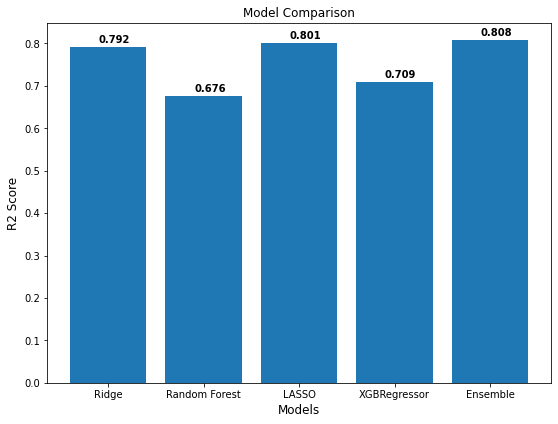

In [ ]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
models = ['Ridge',  'Random Forest', 'LASSO','XGBRegressor', 'Ensemble']

r2_score_list = [round(df_mean.R2score[0],3),
                 round(df_mean.R2score[1],3),
                 round(df_mean.R2score[2],3),
                 round(df_mean.R2score[3],3),
                 round(df_mean.R2score[5],3)
                 ]

ax.bar(models,r2_score_list)
ax.set_ylabel('R2 Score',fontsize= 12)
ax.set_xlabel('Models',fontsize= 12)
ax.set_title('Model Comparison')
for i, v in enumerate(r2_score_list):
  ax.text(i - 0.1,v + 0.01, str(v), color='black', fontweight='bold')
#plt.savefig('barplot_1.png',dpi=200, format='png', bbox_inches='tight')
plt.show()

In [20]:
for i in tqdm(range(n), desc='Mulitple Run Progress'):
  print()
  print("Run Number ",i+1)
  x_train,x_test,y_train,y_test = train_test_split(dataset,y,test_size=0.2)
  combine = x_train.append(x_test)
  combine.drop(columns=["frame","waist","hdl","height","location","gender"],inplace=True)
  x_train = combine.iloc[:322]
  x_test = combine.iloc[322:]

  ## Machine Learning

  ## Ridge
  ridge_reg = Ridge()
  params_Ridge = {'alpha': [1,0.1,0.01,0.001,0.0001,0] , "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
  Ridge_GS = GridSearchCV(ridge_reg, param_grid=params_Ridge, n_jobs=-1, cv=10)
  Ridge_GS.fit(x_train,y_train)
  Ridge_best_model = Ridge_GS.best_estimator_
  Ridge_best_model.fit(x_train,y_train)
  y_Ridge_GS_pred= Ridge_best_model.predict(x_test)
  t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,y_Ridge_GS_pred)
  df.loc[len(df.index)] = [i+1,"Ridge",r2score,MSE,MAE,MAD,RMSE]


  ## Linear Regression
  model_lr = LinearRegression()
  params_lr = {"fit_intercept": [True, False]}
  lr_GS = GridSearchCV(model_lr, param_grid=params_lr, n_jobs=-1,cv=10)
  lr_GS.fit(x_train,y_train)
  Lr_best_model = lr_GS.best_estimator_
  Lr_best_model.fit(x_train,y_train)
  y_lr_GS_pred= Lr_best_model.predict(x_test)
  t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,y_lr_GS_pred)
  df.loc[len(df.index)] = [i+1,"Linear Reg",r2score,MSE,MAE,MAD,RMSE]


  ## lasso
  lasso_reg = Lasso()
  params_lasso = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03] , "fit_intercept": [True, False]}
  lasso_GS = GridSearchCV(lasso_reg, param_grid=params_lasso, n_jobs=-1,cv=10)
  lasso_GS.fit(x_train,y_train)
  Lasso_best_model = lasso_GS.best_estimator_
  Lasso_best_model.fit(x_train,y_train)
  y_lasso_GS_pred= Lasso_best_model.predict(x_test)
  t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,y_lasso_GS_pred)
  df.loc[len(df.index)] = [i+1,"Lasso",r2score,MSE,MAE,MAD,RMSE]


  ## ANN
  model = Sequential()
  model.add(Dense(9, input_dim=9, kernel_initializer='normal', activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='linear'))
  # Compile model
  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
  mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history=model.fit(x_train, y_train, epochs=50, batch_size=5, verbose=0, validation_split=0.2,callbacks=[mc])
  saved_model = load_model('best_model.h5')
  y_ann_pred = saved_model.predict(x_test)
  t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,y_ann_pred)
  df.loc[len(df.index)] = [i+1,"ANN",r2score,MSE,MAE,MAD,RMSE]
  y_ann_pred=y_ann_pred.reshape((81,))


  ## Ensemble Learning with Average weights
  Ensemble_average_prediction_1 = ( y_ann_pred+ y_lasso_GS_pred+ y_lr_GS_pred + y_Ridge_GS_pred ) / 4
  #print(metrics(y_test,Ensemble_average_prediction_1))
  t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,Ensemble_average_prediction_1)
  df.loc[len(df.index)] = [i+1,"Ensemble Avg Weight",r2score,MSE,MAE,MAD,RMSE]


  ## Ensemble Learning with Optimized Weights
  rmse_optimize =[]
  def rmse_loss_func(weights):
      ''' scipy minimize will pass the weights as a numpy array '''
      final_prediction = 0
      for weight, prediction in zip(weights, predictions):
              final_prediction += weight*prediction

      #print(np.sqrt(mean_squared_error(y_test,final_prediction)),weights)
      rmse_optimize.append(np.sqrt(mean_squared_error(y_test,final_prediction)))
      return np.sqrt(mean_squared_error(y_test,final_prediction))
  # add every model's prediction into list
  predictions = []
  predictions.append(y_Ridge_GS_pred)
  predictions.append(y_ann_pred)
  predictions.append(y_lasso_GS_pred)
  predictions.append(y_lr_GS_pred)
  starting_values = [0.5]*len(predictions)
  res = minimize(rmse_loss_func, starting_values, method='Powell')
  best_weights=res["x"]
  w1,w2,w3,w4 = best_weights[0],best_weights[1],best_weights[2],best_weights[3]
  df_weights.loc[len(df_weights.index)] = [i+1,w1,w2,w3,w4]
  Ensemble_average_prediction_2 = ( y_lr_GS_pred*w4+ y_lasso_GS_pred*w3 + y_ann_pred*w2 +
                                  y_Ridge_GS_pred*w1)
  
  t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,Ensemble_average_prediction_2)
  print(t)
  df.loc[len(df.index)] = [i+1,"Ensemble Optimized Weight",r2score,MSE,MAE,MAD,RMSE]
  print("-----------------------------------------------------------------------")


Mulitple Run Progress:   0%|          | 0/2 [00:00<?, ?it/s]


Run Number  1


Mulitple Run Progress:  50%|█████     | 1/2 [00:14<00:14, 14.83s/it]

+--------------+--------------------+
| Error Metric |       Value        |
+--------------+--------------------+
|   r2_score   | 0.5551722525144931 |
|     MSE      | 2.056495492212515  |
|     MAE      | 0.8973657454841645 |
|     RMSE     | 1.4340486366272642 |
|     MAD      | 1.1690582918266565 |
+--------------+--------------------+
-----------------------------------------------------------------------

Run Number  2


Mulitple Run Progress: 100%|██████████| 2/2 [00:24<00:00, 12.38s/it]

+--------------+--------------------+
| Error Metric |       Value        |
+--------------+--------------------+
|   r2_score   | 0.6381211305257479 |
|     MSE      | 2.165251975476092  |
|     MAE      | 0.9546681031597103 |
|     RMSE     | 1.4714795192173393 |
|     MAD      |  1.43343986563597  |
+--------------+--------------------+
-----------------------------------------------------------------------
